In [20]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import json
import os


# Load point cloud from .ply file
pcd = o3d.io.read_point_cloud("/home/rafic/projects/phd_course/meshroom/sparse.ply")
o3d.visualization.draw_geometries([pcd])

Number of points before filtering: 2122
Number of points after filtering: 1910

Number of points before filtering: 2122
Number of points after filtering: 1801

Number of points before filtering: 2122
Number of points after filtering: 1866

Number of points before filtering: 2122
Number of points after filtering: 1866

Number of points before filtering: 2122
Number of points after filtering: 1710

Number of points before filtering: 2122
Number of points after filtering: 1799

Number of points before filtering: 2122
Number of points after filtering: 1856

Number of points before filtering: 2122
Number of points after filtering: 1848

Number of points before filtering: 2122
Number of points after filtering: 1681

Number of points before filtering: 2122
Number of points after filtering: 1736

Number of points before filtering: 2122
Number of points after filtering: 1803



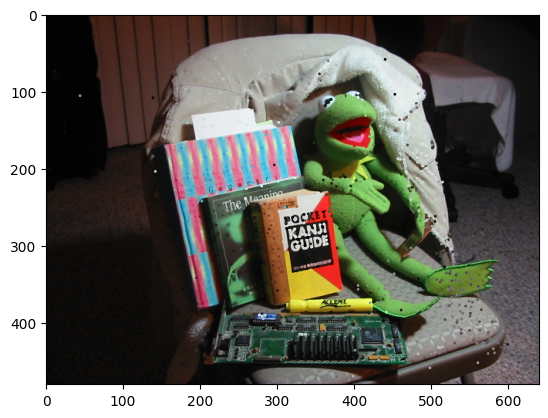

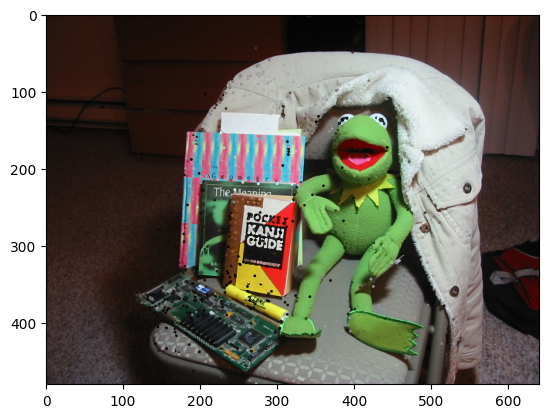

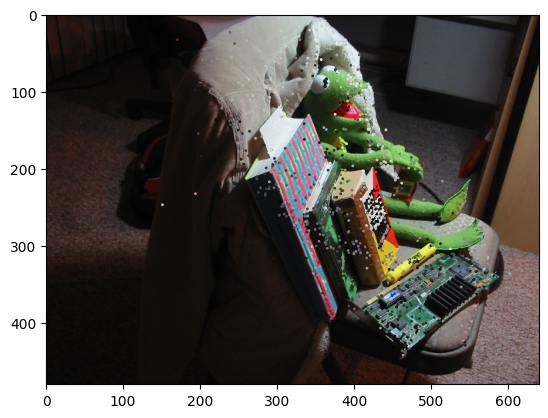

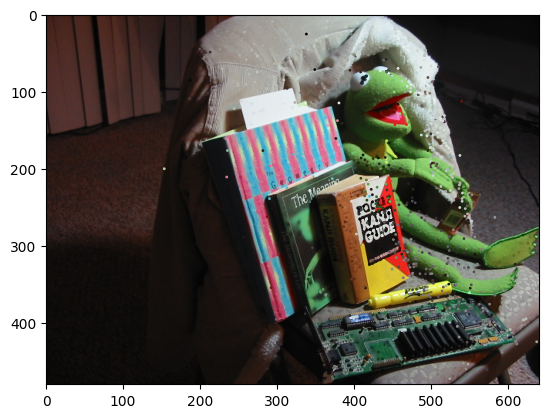

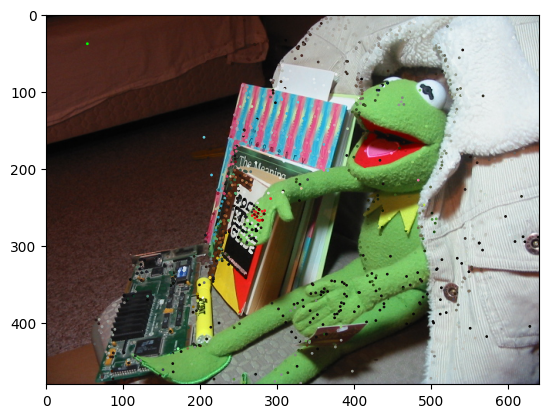

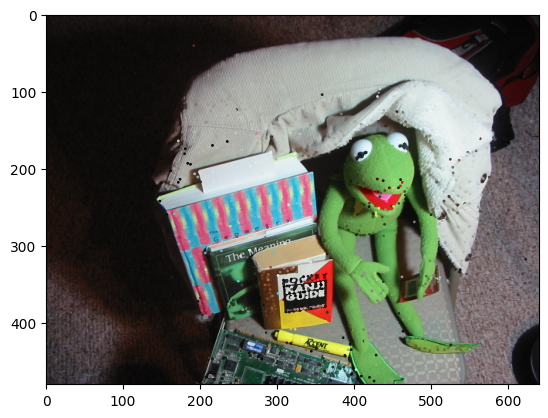

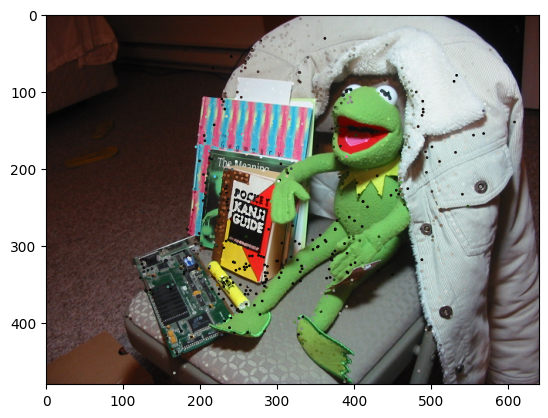

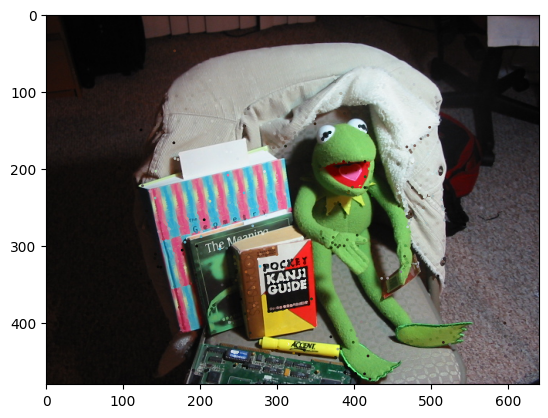

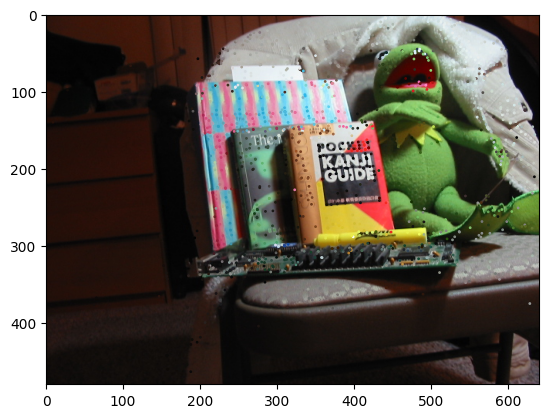

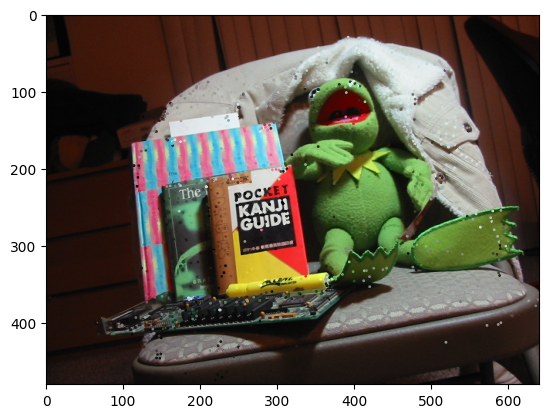

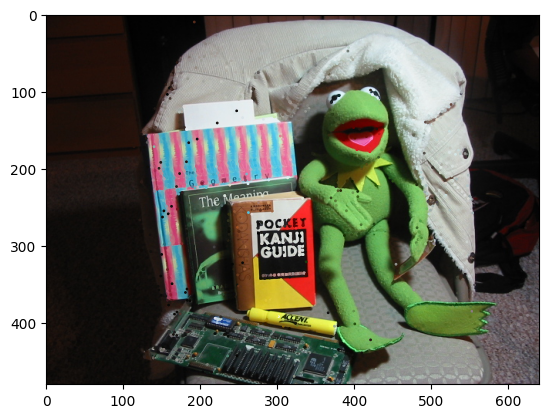

In [27]:

# Load camera poses and intrinsic parameters from cameras.sfm file
# Load all original images

with open("/home/rafic/projects/phd_course/meshroom/cameras.sfm", "r") as f:
    data = json.load(f)
    poses = {pose["poseId"]: pose["pose"]["transform"] for pose in data["poses"]}
    intrinsics = {intrinsic["intrinsicId"]: intrinsic for intrinsic in data["intrinsics"]}
    images = {view["viewId"]:view["path"] for view in data["views"]}


# Project point cloud to image plane for each camera pose
for pose_id, pose in poses.items():
    # Convert rotation and translation from string to numpy array
    R = np.array(pose["rotation"]).reshape(3, 3)
    R = np.array(R, dtype=np.float32)
    R = np.transpose(R)
    C = np.array(pose["center"]).astype(np.float32)
    t = -np.dot(R, C)

    # Get intrinsic parameters for current camera
    # should have in pose
    # intrinsic_id = pose["intrinsicId"]
    intrinsic_id = list(intrinsics.keys())[0] 
    fx = float(intrinsics[intrinsic_id]["pxFocalLength"])
    fy = float(intrinsics[intrinsic_id]["pxFocalLength"])
    cx = float(intrinsics[intrinsic_id]["principalPoint"][0])
    cy = float(intrinsics[intrinsic_id]["principalPoint"][1])
    k1 = float(intrinsics[intrinsic_id]["distortionParams"][0])
    k2 = float(intrinsics[intrinsic_id]["distortionParams"][1])
    k3 = float(intrinsics[intrinsic_id]["distortionParams"][2])
    # Get camera matrix from intrinsic parameters
    K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]], dtype=np.float32)

    # Project point cloud to image plane
    points_3d = np.asarray(pcd.points)
    rvec, _ = cv2.Rodrigues(R)
    tvec = t.reshape((3, 1))
    tvec = np.array(tvec, dtype=np.float32)
    dist_coeffs = np.array([k1, k2, 0, 0, k3])
    points_2d, _ = cv2.projectPoints(points_3d, rvec, tvec, K, dist_coeffs)
    pcd_2d = points_2d.reshape((-1, 2))
    
    
    # Get colors of the projected points
    colors = np.asarray(pcd.colors)
    colors_2d = colors.reshape((-1, 3))

    # Load original image
    img = cv2.imread(f"/home/rafic/projects/phd_course/meshroom/photos/{os.path.split(images[pose_id])[1]}")
    img_height, img_width, _ = img.shape
      
    # Create a depth buffer with the maximum depth value
    depth_buffer = np.full((img_height, img_width), np.inf)
    points_depth = points_3d[:, 2]  # Z coordinates of the points in camera coordinates
     
      
    # Filter out the points that are not visible to the camera
    visible_points_2d = []
    visible_colors_2d = []
    visible_depths = []
    for i, point in enumerate(pcd_2d):
        x, y = point
        if 0 <= x < img_width and 0 <= y < img_height:
            # Check if the point is closer to the camera than the current depth value in the buffer
            if points_depth[i] < depth_buffer[int(y), int(x)]:
                visible_points_2d.append(point)
                visible_colors_2d.append(colors_2d[i])
                visible_depths.append(points_depth[i])
                depth_buffer[int(y), int(x)] = points_depth[i]
    print(f"Number of points before filtering: {len(pcd_2d)}")
    print(f"Number of points after filtering: {len(visible_points_2d)}\n")
    visible_points_2d = np.asarray(visible_points_2d)
    visible_colors_2d = np.asarray(visible_colors_2d)
    
    


    # Plot projected point cloud on top of original image
    fig, ax = plt.subplots()
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.scatter(visible_points_2d[:, 0], visible_points_2d[:, 1], s=1, c=visible_colors_2d, marker='o')
    ax.set_xlim([0, img_width])
    ax.set_ylim([img_height, 0])

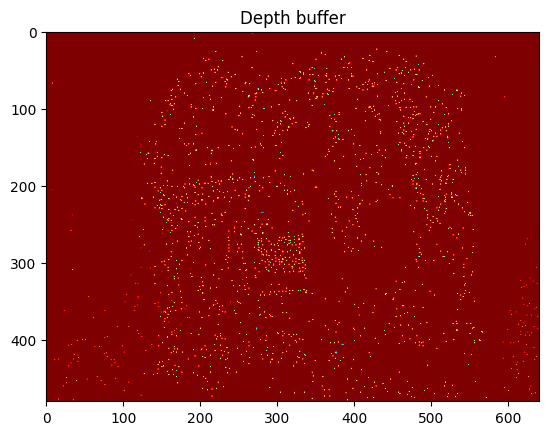

In [24]:
# Replace inf values with maximum depth value
max_depth = np.max(depth_buffer[depth_buffer != np.inf])
depth_buffer[depth_buffer == np.inf] = max_depth

# Plot depth buffer as image
fig, ax = plt.subplots()
ax.imshow(depth_buffer, cmap='jet')
ax.set_title("Depth buffer")
plt.show()

In [ ]:
# Replace inf values with maximum depth value
max_depth = np.max(depth_buffer[depth_buffer != np.inf])
depth_buffer[depth_buffer == np.inf] = max_depth

# Plot depth buffer as image
fig, ax = plt.subplots()
ax.imshow(depth_buffer, cmap='jet')
ax.set_title("Depth buffer")
plt.show()

In [31]:
# Assuming that visible_points_2d and visible_depths contain the 2D points and depth values, respectively
# Reconstruct 3D points
visible_points_3d = []
for i, point_2d in enumerate(visible_points_2d):
    x, y = point_2d
    Z = visible_depths[i]
    X = (x - cx) * Z / fx
    Y = (y - cy) * Z / fy
    point_3d = np.array([X, Y, Z], dtype=np.float32)
    visible_points_3d.append(point_3d)

visible_points_3d = np.asarray(visible_points_3d)

In [32]:
import open3d as o3d
import numpy as np

# visible_points_3d and visible_colors_3d are numpy arrays containing the filtered 3D points and their colors
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(visible_points_3d)
pcd.colors = o3d.utility.Vector3dVector(visible_colors_2d)

o3d.visualization.draw_geometries([pcd])